In [916]:
#Objective : To predict the housing prices in Australia using advanced regression

In [917]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.linear_model import Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [918]:
#import dataset
data=pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [919]:
#Data Inspection
data.shape

(1460, 81)

1460 records with 81 columns present in data

In [920]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [921]:
# data[['MSSubClass','YearBuilt','YearRemodAdd','GarageYrBlt']]=data[['MSSubClass','YearBuilt','YearRemodAdd','GarageYrBlt']].astype('object')
data[['MSSubClass']]=data[['MSSubClass']].astype('object')

In [922]:
data.dtypes.value_counts()

object     44
int64      34
float64     3
dtype: int64

43 text features and 38 numeric features

In [923]:
#Missing value ratio
#Removing columns having more than 75% missing values in entries
perc=data.isna().sum()/len(data)
cols_to_del = [col for col,val in perc.items() if val>0.75]
print("Columns removed",cols_to_del)

Columns removed ['Alley', 'PoolQC', 'Fence', 'MiscFeature']


In [924]:
#Remove ID column since it has unique values and not useful for prediction
cols_to_del.append("Id")
data.drop(columns=cols_to_del,inplace=True)
data.shape

(1460, 76)

In [925]:
dup_rows=data.duplicated().sum()
print("Duplicate records present in data are:",dup_rows)

Duplicate records present in data are: 0


In [926]:
#Removing columns with low variation in data
#Check categorical data
data_cat=data.select_dtypes(include=['object'])
cat_cols=list(data_cat.columns)
# print(len(cat_cols))
#Identify columns which have more than 90% of same category value
data_cols_var=[]
for cat in cat_cols:
    val_cnt=pd.DataFrame(data_cat[cat].value_counts(normalize=True))
    if float(val_cnt.max())>=0.9:
        data_cols_var.append(cat)
del_len=len(data_cols_var)
print(f"{del_len} Categorical Columns with more than 90% of single category : {data_cols_var}")

13 Categorical Columns with more than 90% of single category : ['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'BsmtCond', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive']


In [927]:
#Remove low variation columns since they are not useful for prediction
data.drop(columns=data_cols_var,inplace=True)
data.shape

(1460, 63)

<AxesSubplot:xlabel='SalePrice'>

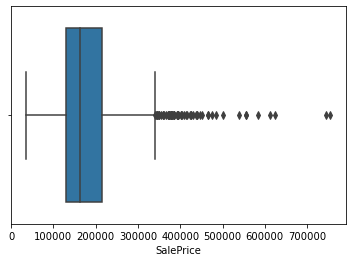

In [928]:
#Removing outliers - Target Variable
sns.boxplot(data["SalePrice"])

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

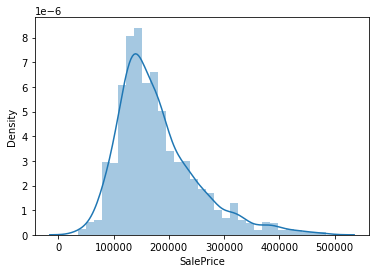

In [929]:
#We observe some outliers in the target Variable, we remove the extreme points above 500000 price
data=data[data["SalePrice"]<500000]
#Observing Distribution of sale price
sns.distplot(data["SalePrice"])

In [930]:
#Impute Missing Values
missing=data.isna().sum()
cols_missing_data = [col for col,val in missing.items() if val>0]
cat_missing_cols=list(data[cols_missing_data].select_dtypes(include=['object']).columns)
num_missing_cols=list(data[cols_missing_data].select_dtypes(include=['int64','float64']).columns)

In [931]:
#Impute using mode for categorical and median for numeric variables
for col in list(data.columns):
    if col in cat_missing_cols:
        mod=data[col].mode()
        data[col].fillna(mod,inplace=True)
    if col in num_missing_cols:
        med=data[col].median()
        data[col].fillna(med,inplace=True)

In [932]:
print(data.shape)

(1451, 63)


There are still 63 features, and its important to select the relevant features correlating with the target variable

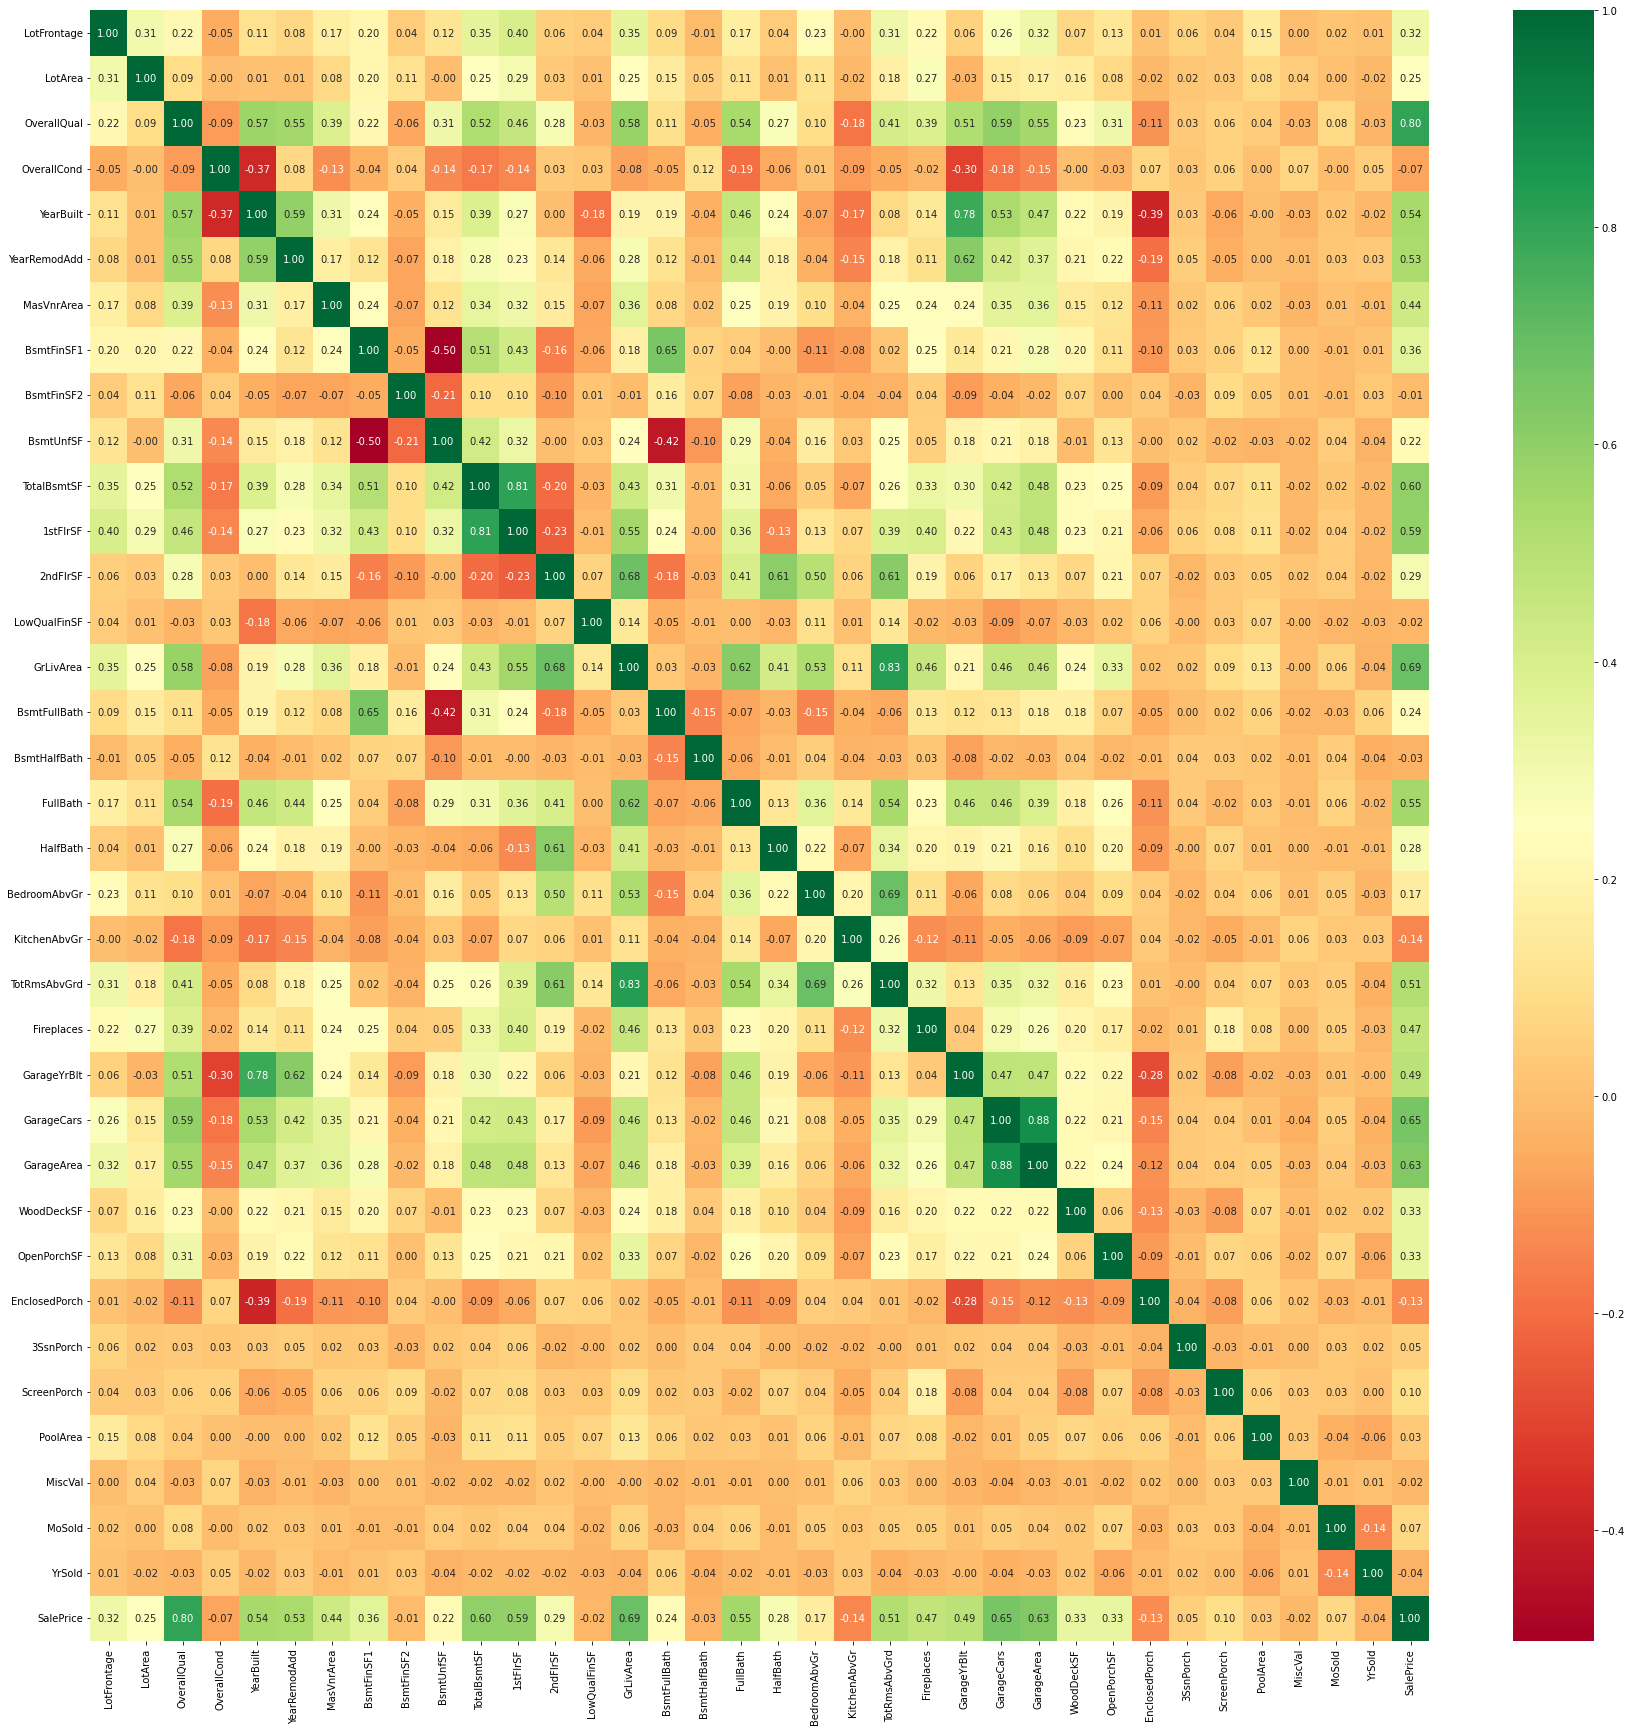

In [933]:
#Checking correlation of numeric variables with target variable
num_cols=list(data.select_dtypes(include=['int64','float64']).columns)
plt.figure(figsize=(30,30))
corr_mat=data[num_cols].corr()
sns.heatmap(corr_mat,cmap="RdYlGn",annot=True,fmt='.2f')
plt.show()

In [934]:
#Removing highly correlated features( corr >= 0.8) - Based on data dictionary understanding
#Correlated Features --> Feature kept in model
# 1. YrBuilt & GarageYrBlt --> YrBuilt
# 2. TotalBsmntSF & 1stFlrSF --> TotalBsmntSF
# 3. TotRmsAbvGrd & GrLivArea --> GrLivArea
# 4. GarageCars & GarageArea --> GarageCars
corr_num_vars=["GarageYrBlt","1stFlrSF","TotRmsAbvGrd","GarageArea"]
#Remove from Data
data.drop(columns=corr_num_vars,inplace=True)
#Top correlating numeric features with Target Variable for EDA along with sale price
num_top=["OverallQual","GrLivArea","GarageCars","FullBath","TotalBsmtSF","SalePrice"]

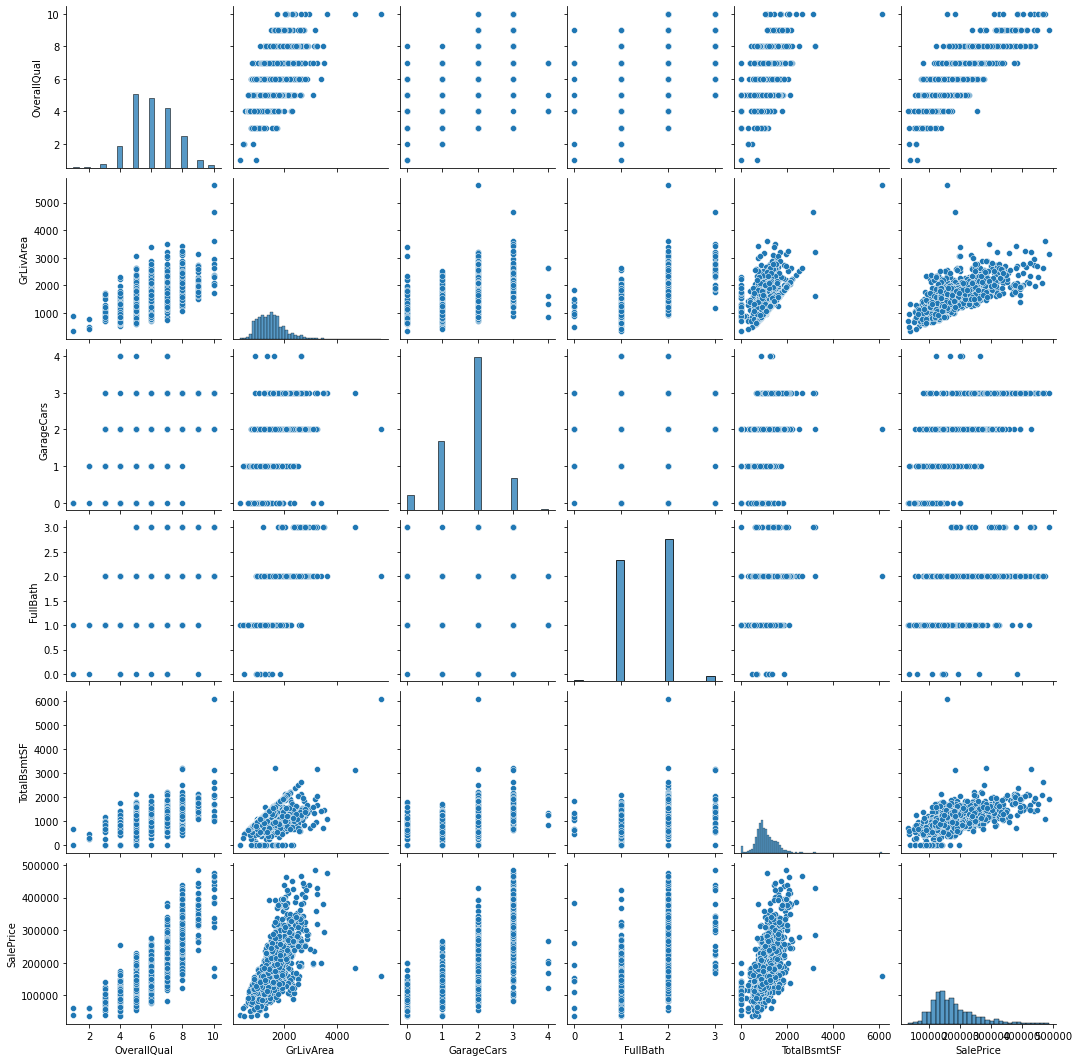

In [935]:
data[num_top]
sns.pairplot(data[num_top])

The numeric features showed a linear correlation with the sale price(target variable), we can use the linear regression framework

Total numeric features 32


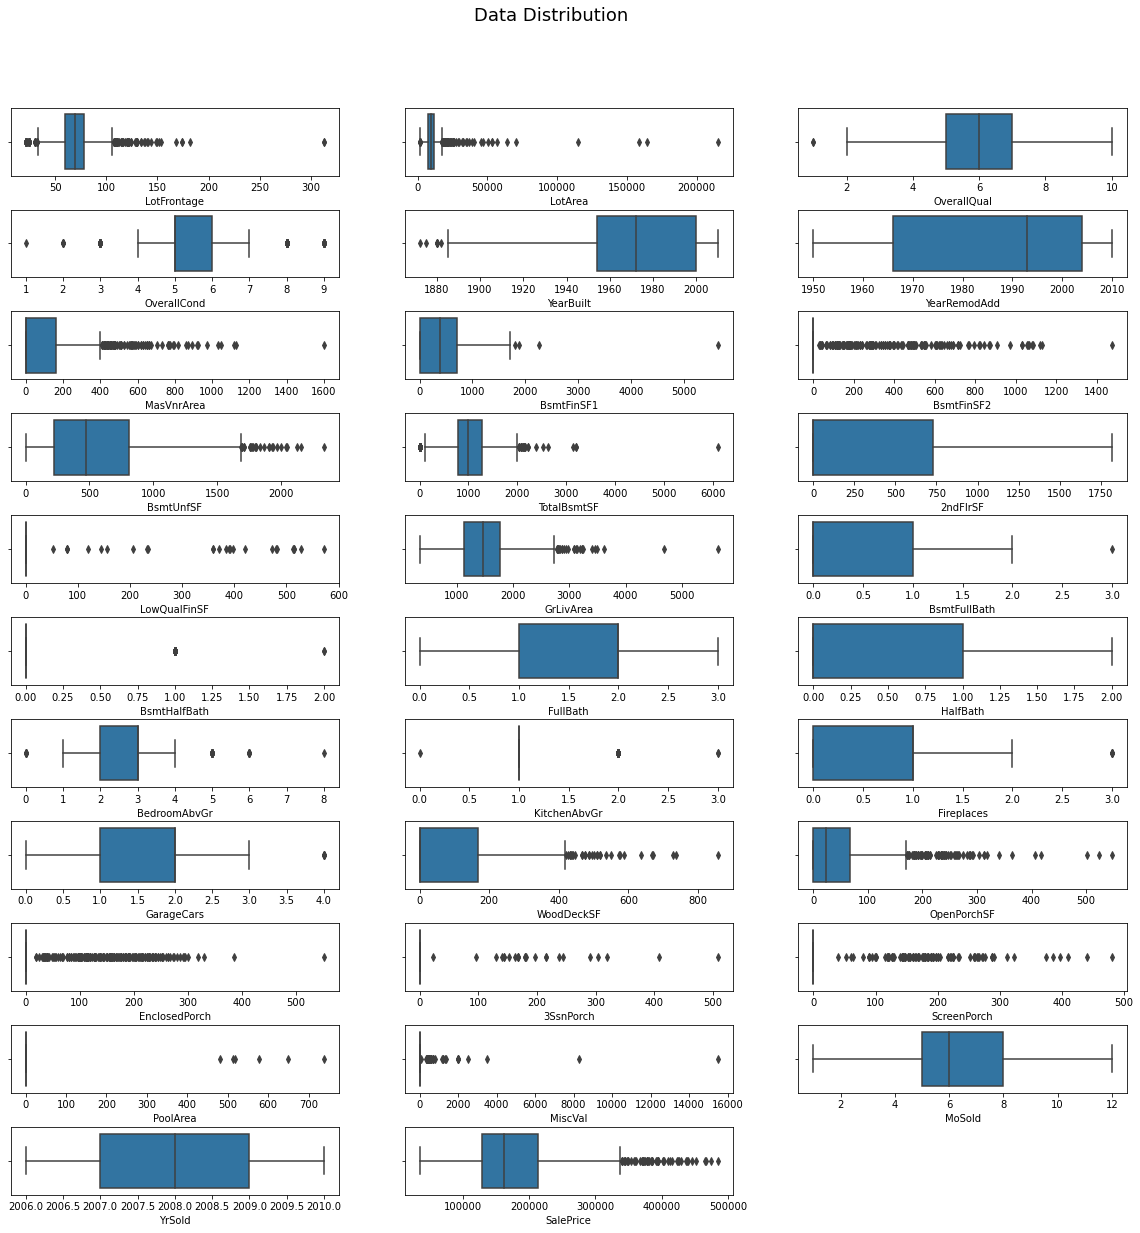

In [936]:
for corrnum in corr_num_vars:
    num_cols.remove(corrnum)
print("Total numeric features",len(num_cols))
tickers = num_cols
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Data Distribution", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for n, ticker in enumerate(tickers):
    # add a new subplot iteratively
    ax = plt.subplot(11, 3, n + 1)

    # filter df and plot ticker on the new subplot axis
    sns.boxplot(data=data,x=ticker)
    ax.set_ylabel("")
plt.show()


In [937]:
#Removing columns with improper distribution in box plots(lots of outliers and no Iqr)
impr_dist_cols=["BsmtHalfBath","MiscVal","PoolArea","KitchenAbvGr","BsmtHalfBath"]
data.drop(columns=impr_dist_cols,inplace=True)
num_cols=list(set(num_cols)-set(impr_dist_cols))        

In [938]:
cat_cols=list(data.select_dtypes(include=['object']).columns)
print(cat_cols)

['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'SaleType', 'SaleCondition']


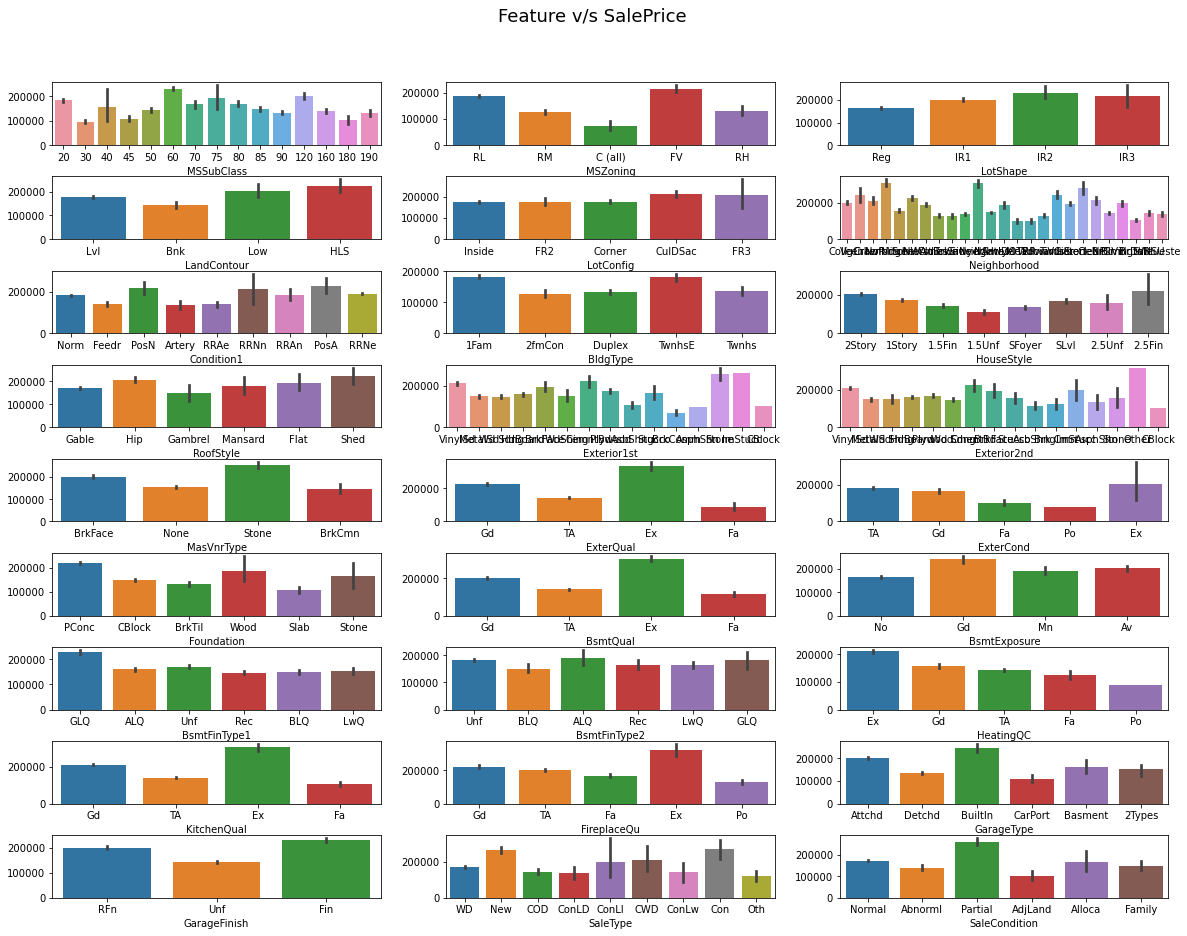

In [939]:
#Check Variation with target variable

tickers = cat_cols
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Feature v/s SalePrice", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for n, ticker in enumerate(tickers):
    # add a new subplot iteratively
    ax = plt.subplot(9, 3, n + 1)

    # filter df and plot ticker on the new subplot axis
    sns.barplot(data=data,x=ticker,y="SalePrice")
    ax.set_ylabel("")


plt.show()

Categorical features seem to show a relation with the sale price

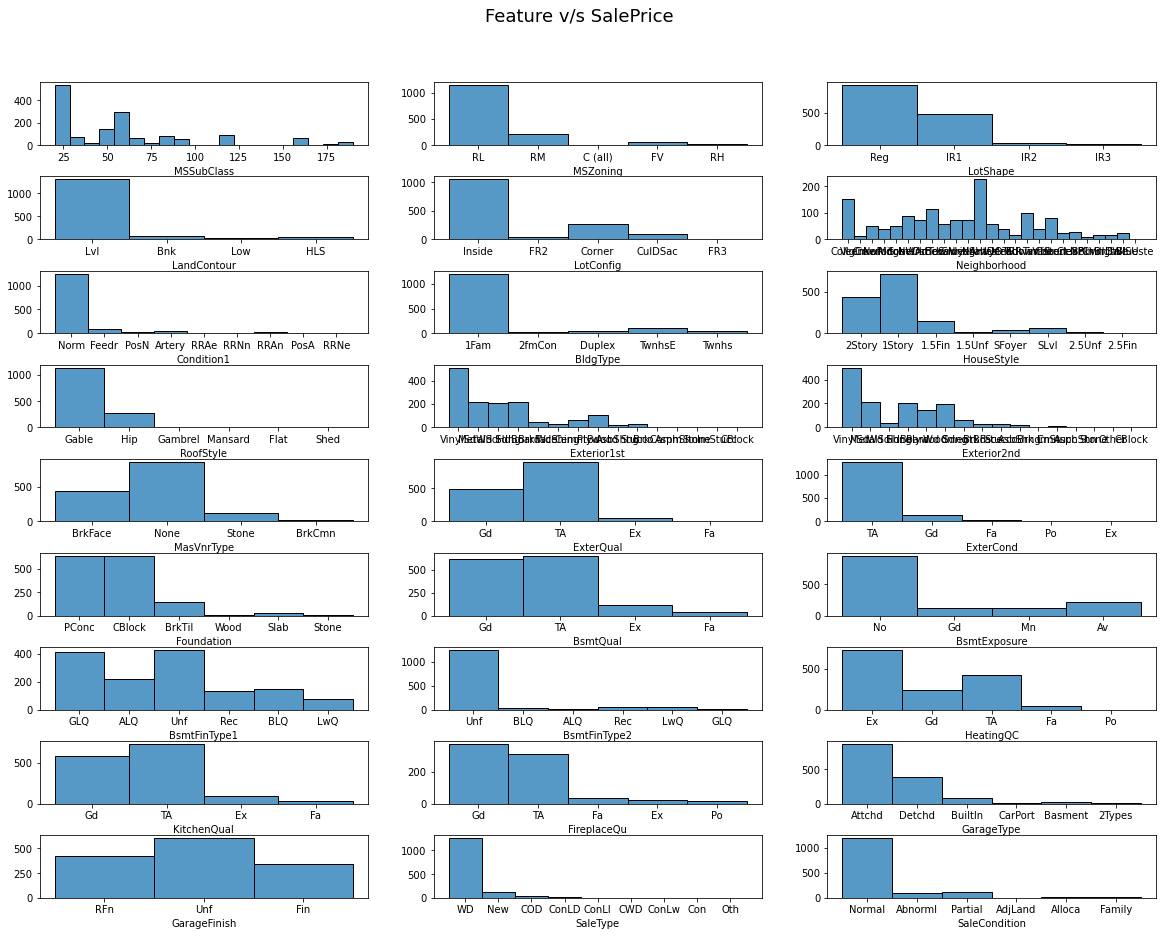

In [940]:
#Check Distribution of data

tickers = cat_cols
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Feature v/s SalePrice", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for n, ticker in enumerate(tickers):
    # add a new subplot iteratively
    ax = plt.subplot(9, 3, n + 1)

    # filter df and plot ticker on the new subplot axis
    sns.histplot(data[ticker])
    ax.set_ylabel("")


plt.show()

Features which show a similar SalePrice or low variation in sale price and have category imbalance amongst all categories can be removed

In [941]:
#Removing features based on data imbalance and low variation of SalePrice
low_var_cat=["Condition1","BsmtFinType1","LotConfig"]
data.drop(columns=low_var_cat,inplace=True)
cat_cols=list(set(cat_cols)-set(low_var_cat))

In [942]:
#EDA - Identifying Important variables based on data dictionary and distribution
top_cat=["MSZoning","GarageFinish","KitchenQual","ExterQual","BsmtQual"]

In [943]:
#Creation of Dummies for categorical variables
data=pd.get_dummies(data,drop_first=True)
print(data.shape)

(1451, 178)


In [944]:
#X & Y data
cols=list(data.columns)
y_col="SalePrice"
cols.remove(y_col)
X=data[cols]
y=data[y_col]

In [945]:
#Test-Train Split - 70-30% split
X_cols=list(data.columns)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
print("X train shape",X_train_orig.shape)
print("y train shape",y_train_orig.shape)
print("X test shape",X_test_orig.shape)
print("y test shape",y_test_orig.shape)

X train shape (1015, 177)
y train shape (1015,)
X test shape (436, 177)
y test shape (436,)


In [946]:
#Reshape ytrain and ytest to array
y_train=y_train_orig.values.reshape(-1,1)
y_test=y_test_orig.values.reshape(-1,1)

In [947]:
#Scaling Features
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train_orig),columns=X_train_orig.columns)
X_test = pd.DataFrame(scaler.transform(X_test_orig),columns=X_train_orig.columns)

In [948]:
#RFE used for feature selection
lr = LinearRegression()
selector = RFE(lr, n_features_to_select=40, step=1)
selector = selector.fit(X_train, y_train)

In [949]:
#Preparing data with best features from RFE
best_features_rfe=list(X_train.columns[selector.support_])
print("The features selected by RFE are :",best_features_rfe)
X_train=X_train[best_features_rfe]
X_test=X_test[best_features_rfe]

The features selected by RFE are : ['LotFrontage', 'OverallQual', 'OverallCond', 'YearBuilt', 'GrLivArea', 'BsmtFullBath', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'MSSubClass_120', 'MSSubClass_160', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'RoofStyle_Gable', 'RoofStyle_Hip', 'Exterior1st_VinylSd', 'Exterior2nd_VinylSd', 'ExterQual_Gd', 'ExterQual_TA', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_TA', 'Foundation_CBlock', 'Foundation_PConc', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtExposure_Gd', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'SaleType_New', 'SaleCondition_Partial']


In [950]:
#Function for linear regression for each set of features
def linear_regression_feature(X_tr,y_tr,vif_flag=1):
    features=list(X_tr.columns)
    #1. Train the model
    X_train_sm = sm.add_constant(X_tr[features])
    lr = sm.OLS(y_tr, X_train_sm).fit()
    print(lr.summary())

    #2. Checking multi-collinearity : VIF
    #If VIF flag is not zero, then only calculate VIF, by default it vif_flag=1
    if vif_flag!=0:
        # VIF
        vif = pd.DataFrame()
        features=X_tr[features]
        vif['Features'] = features.columns
        vif['VIF'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
        vif['VIF'] = round(vif['VIF'], 2)
        vif = vif.sort_values(by = "VIF", ascending = False)
        print(vif)
    return lr

In [951]:
#Checking multicollinearity and significance of variables
lr=linear_regression_feature(X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     171.6
Date:                Sun, 03 Jul 2022   Prob (F-statistic):               0.00
Time:                        18:39:50   Log-Likelihood:                -11749.
No. Observations:                1015   AIC:                         2.358e+04
Df Residuals:                     974   BIC:                         2.378e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.794e+

We can find multicollinearity and insignificant variables in the data for linear regression model

In [952]:
X_train.drop("SaleType_New",axis=1,inplace=True)
lr=linear_regression_feature(X_train,y_train)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     172.2
Date:                Sun, 03 Jul 2022   Prob (F-statistic):               0.00
Time:                        18:39:50   Log-Likelihood:                -11759.
No. Observations:                1015   AIC:                         2.360e+04
Df Residuals:                     975   BIC:                         2.379e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.794e+

Exterior features might be correlated leading to high VIF, hence removing features leading to multi-collinearity and have high p-values also and based on understanding from data dictionary

In [953]:
X_train.drop(["ExterQual_TA","ExterQual_Gd","Exterior1st_VinylSd","Exterior2nd_VinylSd","ExterCond_Fa","ExterCond_TA","ExterCond_Gd"],axis=1,inplace=True)
lr=linear_regression_feature(X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     206.3
Date:                Sun, 03 Jul 2022   Prob (F-statistic):               0.00
Time:                        18:39:50   Log-Likelihood:                -11770.
No. Observations:                1015   AIC:                         2.361e+04
Df Residuals:                     982   BIC:                         2.377e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.794e+

In [954]:
#Roof Style variable has high VIF and p-values, hence removing them
X_train.drop(["RoofStyle_Hip","RoofStyle_Gable"],axis=1,inplace=True)
lr=linear_regression_feature(X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     219.0
Date:                Sun, 03 Jul 2022   Prob (F-statistic):               0.00
Time:                        18:39:50   Log-Likelihood:                -11773.
No. Observations:                1015   AIC:                         2.361e+04
Df Residuals:                     984   BIC:                         2.376e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.794e+

In [955]:
#Roof Style variable has high VIF and p-values, hence removing them
X_train.drop(["KitchenQual_TA","KitchenQual_Gd","KitchenQual_Fa"],axis=1,inplace=True)
lr=linear_regression_feature(X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     230.6
Date:                Sun, 03 Jul 2022   Prob (F-statistic):               0.00
Time:                        18:39:50   Log-Likelihood:                -11798.
No. Observations:                1015   AIC:                         2.365e+04
Df Residuals:                     987   BIC:                         2.379e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.794e+

Model is now free from high multi-collinearity and all the features are also significant according to p-values

In [956]:
final_cols=list(X_train.columns)
X_test=X_test[final_cols]
num_cols=len(final_cols)
print(f"After data preparation and feature selection, we are left with {num_cols} columns for advanced regression")

After data preparation and feature selection, we are left with 27 columns for advanced regression


In [957]:
#Function for Test & Train Metrics
def report_metrics(model,X_tst,y_tst,model_name):
    print(f"The best value of lambda(alpha) found in {model_name} Regression is :",list(model.best_params_.values())[0])
    r2_train_score=model.best_score_
    r2_test_score=metrics.r2_score(y_tst, model.predict(X_tst))
    test_mean_squared_score=metrics.mean_squared_error(y_tst, model.predict(X_tst))
    print("Train R2 score is :",round(r2_train_score,3))
    print("Test R2 score is  :",round(r2_test_score,3))
    print("Test RMSE score is  :",round(np.sqrt(test_mean_squared_score),3))

In [911]:
#Ridge Regression
parameters = {'alpha':list(range(0,1000,10))}
model = Ridge()
Ridge_reg= GridSearchCV(model, parameters, scoring='r2',cv=5)
Ridge_reg.fit(X_train,y_train)
report_metrics(Ridge_reg,X_test,y_test,"Ridge")

The best value of lambda(alpha) found in Ridge Regression is : 70
Train R2 score is : 0.831
Test R2 score is  : 0.851
Test RMSE score is  : 26625.563


In [912]:
#Lasso Regression
parameters = {'alpha':list(range(0,1000,10))}
model = Lasso()
Lasso_reg= GridSearchCV(model, parameters, scoring='r2',cv=5)
Lasso_reg.fit(X_train,y_train)
report_metrics(Lasso_reg,X_test,y_test,"Lasso")

The best value of lambda(alpha) found in Lasso Regression is : 30
Train R2 score is : 0.829
Test R2 score is  : 0.847
Test RMSE score is  : 26949.874


#### Inferences :
-The optimal value of lambda for Ridge is 70 and for Lasso the optimal lambda is 30<br>
-We select Ridge as the best model, since it has marginally higher train and test R2 and marginally lower RMSE as compared to Lasso regularization<br>
-The Rsquare of the best model in training is 0.83 and in test is 0.85<br>

In [961]:
ridge_coeff=pd.DataFrame(Ridge_reg.best_estimator_.coef_.transpose(), X_train.columns, columns=['Ridge Coefficients'])
lasso_coeff=pd.DataFrame(Lasso_reg.best_estimator_.coef_, X_train.columns, columns=['Lasso Coefficients'])
coeff_model=pd.concat([ridge_coeff,lasso_coeff],axis=1)
print("The coefficients of models in Ridge and Lasso regression are : \n",coeff_model.sort_values(by='Ridge Coefficients',ascending=False))

The coefficients of models in Ridge and Lasso regression are : 
                        Ridge Coefficients  Lasso Coefficients
OverallQual                  19184.405218        20135.571927
GrLivArea                    19131.722207        20615.317522
Neighborhood_NridgHt         10844.775576        11269.875541
GarageCars                    9981.992220         9577.304615
YearBuilt                     9285.674254         9889.707185
OverallCond                   6476.406985         7072.102967
Neighborhood_NoRidge          6263.093184         6480.969410
Fireplaces                    6136.122317         5579.955481
BsmtFullBath                  5813.427758         5941.553045
Foundation_PConc              5574.278509         6440.199415
Neighborhood_Somerst          5491.151274         6084.263895
Neighborhood_Crawfor          5377.324053         5681.327796
Neighborhood_StoneBr          5008.112991         5327.519610
WoodDeckSF                    4625.272995         4378.787865
BsmtE

#### Based on the coefficients of our model, we can infer the important variables as:
1. OverallQual
2. GrLivArea
3. Neighbourhood
4. MsSubClass        
5. BsmtQual
6. YearBuilt            

In [960]:
y_pred_test=Ridge_reg.predict(X_test)

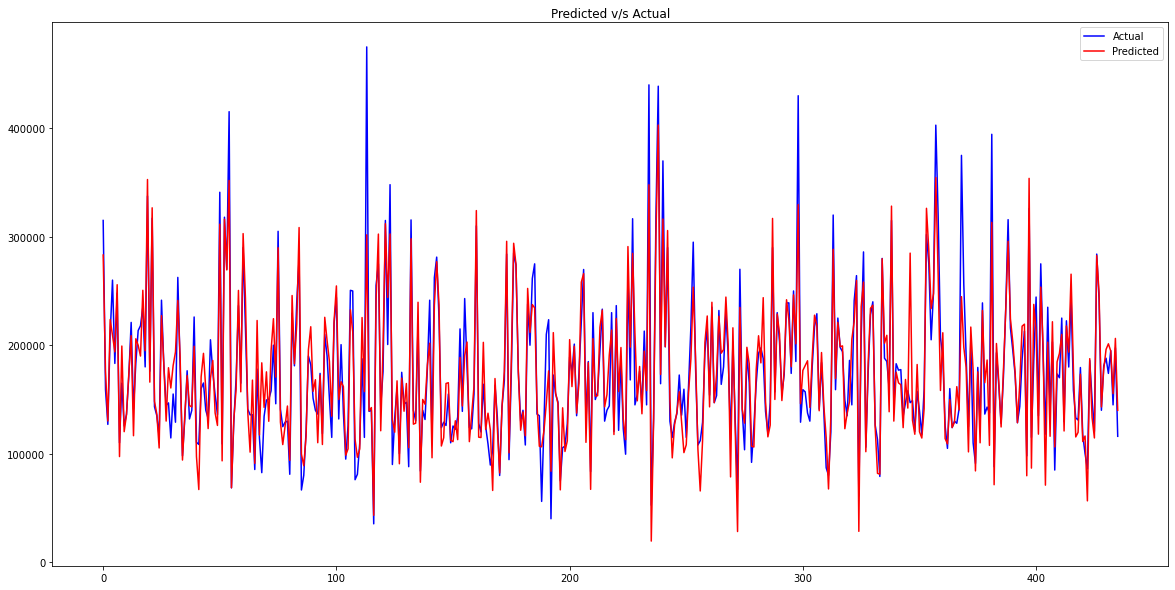

In [979]:
#Checking the predictions
x_vals=[i for i in range(len(y_test))]
plt.figure(figsize=(20,10))
plt.plot(x_vals,y_test,color='blue',label="Actual")
plt.plot(x_vals,y_pred_test,color='red',label="Predicted")
plt.legend()
plt.title("Predicted v/s Actual")
plt.show()

In [ ]:
#For high values of Sales Price, the model is not able to predict, but on a general trend it is able to fit the data actual points

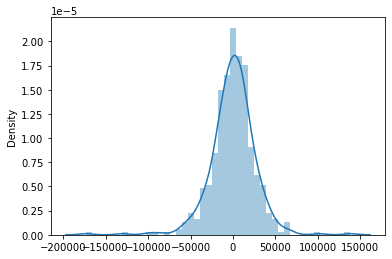

In [980]:
#Residual Distribution
res=y_pred_test-y_test
sns.distplot(res)
plt.show()

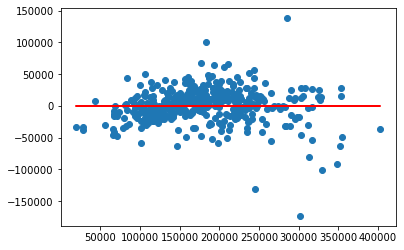

In [987]:
#Y Pred v.s Residuals
plt.scatter(y_pred_test,res)
plt.plot(y_pred_test,[0]*len(y_pred_test),color='red')
plt.show()

In [ ]:
# The residuals has a higher variance when the sale price is above 300000

Overall,the assumptions of linear regression are satisfied, residuals follow a normal distribution and the model can be used to predict the house prices in Australia

#### Conclusions -
I. Data was cleaned and prepared, features were selected through RFE by coarse tuning and through VIF and p-values by fine tuning<br>
I. Optimal value of lambda for lasso is 30 and for ridge it is 70<br>
II. Advanced Regression : Ridge regression seemed to perform better than lasso with a test R-square value of 0.85<br> 
II. The important variables for the prediction of sales price of houses are:<br>
1. OverallQual
2. GrLivArea
3. Neighbourhood
4. MsSubClass        
5. BsmtQual
6. YearBuilt 

# End of Notebook